Set up Colab requirements if in Colab, or autoreload if in jupyter

In [1]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2
    

In [2]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import seaborn as sns

sns.set_style('white')


In [8]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()

As direction calculation can get quite noisy at low speeds, we remove driving under 30 km/h. 

# Calculate offset and append to all dataframes
The output of the cell is already stored and loaded

In [9]:
# from calculate_offset import batch_append_offset
# trip_dfs_out = batch_append_offset(trip_dfs, trip_names, road_dfs, save_path=None)

# Create labeled time windows

Select trip and device

<img src="figures/sections.jpg" width=200 height=300 />

In [10]:
trip_dfs[0][1]

,t,date,lat_gps,lon_gps,alt,speed,speed3D,fix,precision,speed_haversine,...,offset,section,road type,lon,lat,strategy metric_road,chunk_match_ix_road,order_road,x,y
0,326.004339,2021-06-04 08:07:24.004000+00:00,51.990312,4.391410,-7.586758,26.702,96.336,3.0,130.0,26.338251,...,5.309097,A,straight,4.391534,51.990217,0.979971,1,170,86611.98382,445115.8338
1,327.050037,2021-06-04 08:07:25.050000+00:00,51.990070,4.391526,-7.615758,26.941,97.200,3.0,130.0,26.881497,...,4.669011,A,straight,4.391636,51.989984,0.979971,1,171,86618.63419,445089.8165
2,328.043659,2021-06-04 08:07:26.043000+00:00,51.989841,4.391639,-7.664758,26.677,96.156,3.0,130.0,26.455484,...,3.814296,A,straight,4.391737,51.989753,0.979971,1,172,86625.21900,445064.0227
3,329.027631,2021-06-04 08:07:27.027000+00:00,51.989616,4.391748,-7.527758,26.130,94.572,3.0,130.0,26.126373,...,3.256938,A,straight,4.391795,51.989621,0.979971,1,173,86629.00140,445049.2831
4,330.005156,2021-06-04 08:07:28.005000+00:00,51.989396,4.391849,-7.522758,25.673,92.268,3.0,130.0,26.293344,...,2.725377,A,straight,4.391939,51.989291,0.979971,1,175,86638.38883,445012.4350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,3620.032928,2021-06-04 08:09:24.972000+00:00,51.989362,4.392275,0.758903,25.026,90.144,3.0,113.0,25.964728,...,7.052898,M,straight,4.392235,51.989211,0.901184,28,3640,86658.59737,445003.2565
2110,3621.007586,2021-06-04 08:09:25.947000+00:00,51.989578,4.392198,0.527903,24.714,88.920,3.0,112.0,24.349668,...,7.857663,M,straight,4.392101,51.989529,0.901184,28,3641,86649.87832,445038.7601
2111,3622.008586,2021-06-04 08:09:26.948000+00:00,51.989788,4.392123,0.393903,24.097,86.904,3.0,128.0,23.790935,...,8.830827,M,straight,4.392064,51.989618,0.901184,28,3642,86647.47267,445048.6962
2112,3623.035928,2021-06-04 08:09:27.975000+00:00,51.990004,4.392038,0.266903,23.510,84.744,3.0,112.0,24.587643,...,9.121007,M,straight,4.391930,51.989937,0.901184,28,3643,86638.75531,445084.3111


Calculate signals

In [12]:
filter_params = {'EWM_SPAN': 3,
                 'MEDFILT_SIZE': 4,
                 'PROJ_DIST_ROLLINGSUM': 3}

trip_dfs = calculate_signals_alltrips(trip_dfs, filter_params)

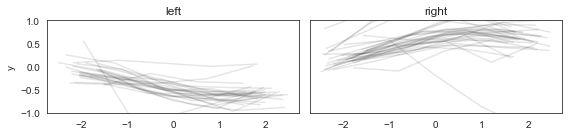

In [14]:
device_nr = 1
sections = ['A', 'M']

window_size=5
fragments = extract_lanechange_fragments_alltrips(trip_dfs, trip_names, lca_dfs, device_nr, sections, window_size)

params = {'ylims': (-1,1),
         'alpha': 0.1,
         'ylabel': 'y'}

plot_col = 'lat_vel_ewmfilt'
plot_fragments(fragments, plot_col, params)

# plt.savefig('figures/lanechanges.png', dpi=600, bbox_inches='tight')
